# Transition Classifier Training Notebook
This notebook creates and trains the classifier model uses transition labels rather than stress level. This notebook can be run after the encoder notebook or on its own. Many of the functions found here are similar to the ones found in the encoder notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from scipy import signal

import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

from tqdm import tqdm

#### Load dataset

In [2]:
def split_filtered_and_raw(filtered_data : list, raw_data : list, random_seed=128) -> list:
    
    autoencoder_split, classifier_split = train_test_split(filtered_data, test_size=0.7, random_state=random_seed, shuffle=True)
    autoencoder_split_raw, classifier_split_raw = train_test_split(raw_data, test_size=0.7, random_state=random_seed, shuffle=True)
    
    # split data into train and test
    autoencoder_train, autoencoder_test = train_test_split(np.array(autoencoder_split), test_size=0.2, random_state=random_seed, shuffle=True)
    autoencoder_train_raw, autoencoder_test_raw = train_test_split(np.array(autoencoder_split_raw), test_size=0.2, random_state=random_seed, shuffle=True)
    
    classifier_train, classifier_test = train_test_split(np.array(classifier_split), test_size=0.2, random_state=random_seed, shuffle=True)
    classifier_train_raw, classifier_test_raw = train_test_split(np.array(classifier_split_raw), test_size=0.2, random_state=random_seed, shuffle=True)

    
    # further split train into validation and train
    autoencoder_train, autoencoder_val = train_test_split(autoencoder_train, test_size=0.2, random_state=random_seed, shuffle=True)
    autoencoder_train_raw, autoencoder_val_raw = train_test_split(autoencoder_train_raw, test_size=0.2, random_state=random_seed, shuffle=True)
    
    classifier_train, classifier_val = train_test_split(classifier_train, test_size=0.2, random_state=random_seed, shuffle=True)
    classifier_train_raw, classifier_val_raw = train_test_split(classifier_train_raw, test_size=0.2, random_state=random_seed, shuffle=True)
    
    
    split_dataset = [autoencoder_train, autoencoder_val, autoencoder_test, autoencoder_train_raw, autoencoder_val_raw, autoencoder_test_raw,
                     classifier_train, classifier_val, classifier_test, classifier_train_raw, classifier_val_raw, classifier_test_raw]
    return split_dataset
    

def load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=4, random_seed=128, num_subjects = 5, subject_choice_seed=128):
    subject_data_files = glob.glob(os.path.join(eeg_ft_dir, '*.csv'))
    # sort the files by the index given to them
    file_name_2_index = lambda file : int(file.split('.')[0].split('_')[-1])
    subject_data_files.sort() # sort alphabetically
    subject_data_files.sort(key=file_name_2_index) # sort by index
    # group data, pick num_subjects randomly
    np.random.seed(subject_choice_seed)
    all_eeg_ft_names = np.random.choice(subject_data_files, size=num_subjects, replace=False)
    print(f"Chosen subjects: {all_eeg_ft_names}")
    
    if cutoff_lf is not None:
        sos = signal.butter(10, cutoff_lf, 'lp', fs=1000, output='sos') # low pass filter
    
    
    full_dataset = []
    for x in all_eeg_ft_names:        
        dataset = []
        unfiltered = []
        
        input_label_pair = pd.read_csv(x).values
        input_label_pair_unfiltered = input_label_pair.copy()
        
        if cutoff_lf is not None:
            input_label_pair[:,2:] = signal.sosfiltfilt(sos, input_label_pair[:,2:], axis=0)
        
        n_chunks = len(input_label_pair)/split_size
        
        split_data = np.array_split(input_label_pair, n_chunks)[:-1].copy()
        split_data_unfiltered = np.array_split(input_label_pair_unfiltered, n_chunks)[:-1].copy()
        
        del input_label_pair_unfiltered
        del input_label_pair
        
        for x_split, y_split in zip(split_data, split_data_unfiltered):
                if len(x_split) >= split_size:
                    dataset.append(x_split[:split_size].copy())
                    unfiltered.append(y_split[:split_size].copy())
                    
        split_dataset = split_filtered_and_raw(dataset, unfiltered, random_seed) # split data into train, validation and test sets
        
        full_dataset.append(split_dataset)
    return convert_loaded_dataset(full_dataset)

def convert_loaded_dataset(full_dataset):
    '''
    convert the full list into individual numpy arrays
    '''
    return [np.vstack([x[i] for x in full_dataset]) for i in range(12) ]

In [3]:
from sklearn.model_selection import train_test_split
dataset = load_and_split_dataset(eeg_ft_dir = 'ALIGNED_DATA', split_size=100, cutoff_lf=4, random_seed=128, num_subjects = 1, subject_choice_seed=55)

classifier_train, classifier_val, classifier_test = dataset[6:9]
classifier_train_raw, classifier_val_raw, classifier_test_raw = dataset[9:]

Chosen subjects: ['ALIGNED_DATA/EEG_FT_ALIGNED_9.csv']


#### Visualize Dataset

1781


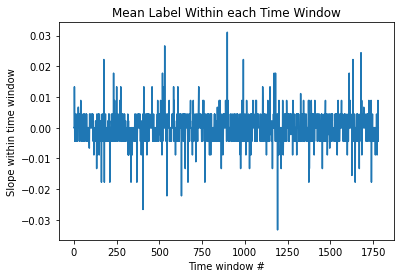

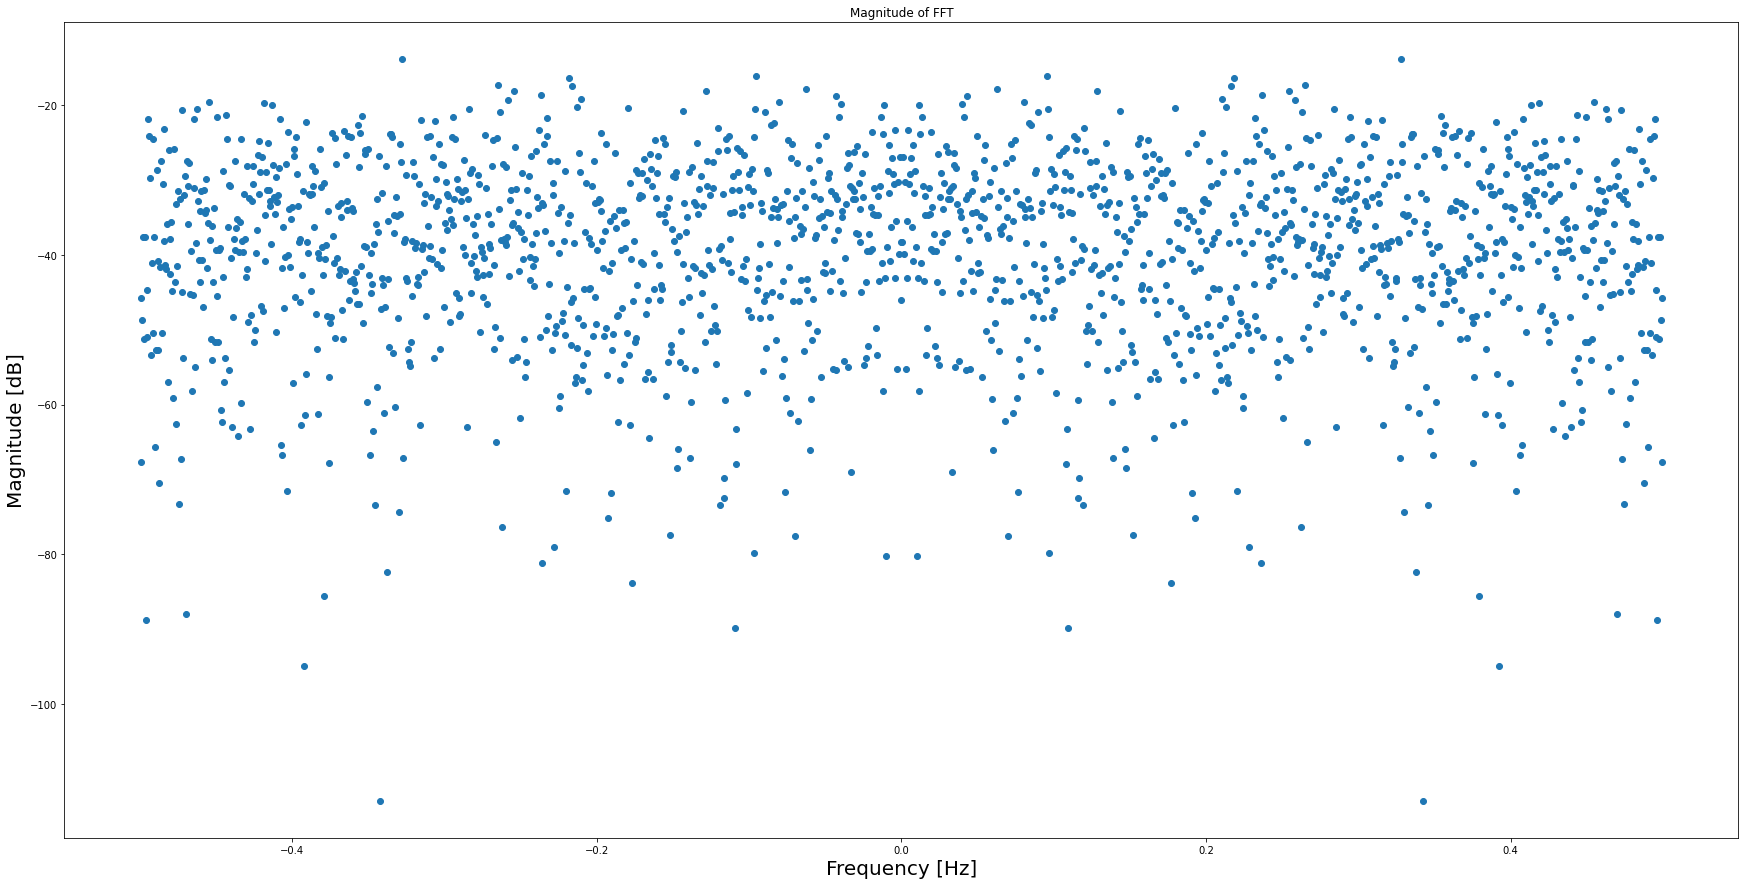

In [4]:
data = np.diff(np.take(classifier_test[:, :, 1], [0,-1], axis=-1)).squeeze()
freq = np.fft.fftfreq(data.size)
print(data.size)
plt.plot(np.arange(data.shape[0]), data)
plt.xlabel("Time window #")
plt.ylabel("Slope within time window")
plt.title("Mean Label Within each Time Window")
fig, axs = plt.subplots(figsize=(30,15))
fft_window = np.abs(np.fft.fft(data))


axs.scatter( freq, 20*np.log(fft_window))

axs.set_xlabel('Frequency [Hz]', fontsize=20);
axs.set_ylabel('Magnitude [dB]', fontsize=20)
axs.set_title(f"Magnitude of FFT")
plt.show()

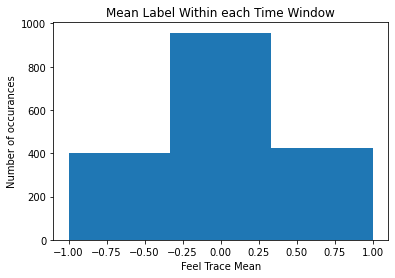

In [5]:
plt.hist(np.sign(data), bins=3)
plt.xlabel("Feel Trace Mean")
plt.ylabel("Number of occurances")
plt.title("Mean Label Within each Time Window")
plt.show()

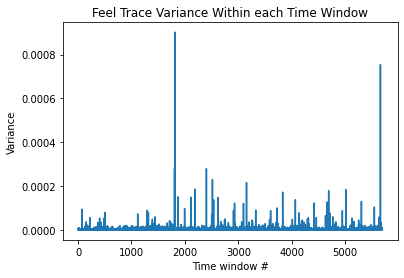

In [6]:
plt.plot(classifier_train[:, :, 1].var(axis=-1))
plt.xlabel("Time window #")
plt.ylabel("Variance")
plt.title("Feel Trace Variance Within each Time Window")
plt.show()

In [7]:
class autoencoder(nn.Module):
    def __init__(self, num_features=12):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Dropout(p=0.0),
            nn.Linear(32, num_features))
        self.decoder = nn.Sequential(
            nn.Linear(num_features, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x


def encode_classifier_data(encoder_path="models/ae_model_100ms_subject_0_4Hz_8_features.pth", classifier_data_in=classifier_test, encoding=8):
    ae_model = autoencoder(encoding)
    ae_model.load_state_dict(torch.load(encoder_path))
    ae_model.eval()
    with torch.no_grad():
        prev_shape = classifier_data_in.shape
        x = torch.from_numpy(classifier_data_in[:,:,2:]).float().reshape(-1,1,64) # eeg channels
        x_encoded = ae_model.encode(x).reshape(prev_shape[0], prev_shape[1], encoding).numpy()

        tmp_arr = np.zeros((prev_shape[0], prev_shape[1], 2 + encoding))
        tmp_arr[:, :, :2] = classifier_data_in[:,:,:2].copy() # copy timestamps and feel trace
        tmp_arr[:,:, 2:] = x_encoded # copy encoded eeg
        return tmp_arr

In [8]:
encoder_path = '1_subjects_seed_55_encoder_8_feat.pth'

classifier_test = encode_classifier_data(encoder_path=encoder_path, classifier_data_in=classifier_test, encoding=8)
classifier_val = encode_classifier_data(encoder_path=encoder_path, classifier_data_in=classifier_val, encoding=8)
classifier_train = encode_classifier_data(encoder_path=encoder_path, classifier_data_in=classifier_train, encoding=8)

In [9]:
classifier_test.shape

(1781, 100, 10)

#### Classifier Model

In [19]:
class lstm_classifier(nn.Module):
    def __init__(self, num_features=12, num_hidden=32, dropout=0.2, n_labels=3):
        super(lstm_classifier, self).__init__()
        
        self.hidden_size = num_hidden*2
        self.num_features = num_features
        self.input_size = num_hidden
        self.n_classses = n_labels
        
        self.lstm_1 = nn.LSTM(
            input_size =  self.num_features,
            hidden_size = self.hidden_size,
            num_layers = 1,
            batch_first=True
        )
        
        self.lstm_2 = nn.LSTM(
            input_size =  self.hidden_size,
            hidden_size = self.input_size,
            num_layers = 1,
            batch_first=True
        )
        
        self.classify = nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(128, self.n_classses))

    
    def forward(self,x):
        x, (h_t, c_t) = self.lstm_1(x)
        x, (h_t, c_t) = self.lstm_2(x)
        x = self.classify(h_t[-1]) # classify last hidden timestep
        return x

In [20]:
def stress_2_label(mean_stress, n_labels=3):
    # value is in [0,1] so map to [0,labels-1] and discretize
    return np.sign(mean_stress) + 1

class classifier_dataset(torch.utils.data.Dataset):
    def __init__(self, X, n_labels=3):
        'Initialization'
        self.x = X
        self.n_labels = n_labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = torch.from_numpy(self.x[index,:,2:]).float() # eeg channels
        y = np.diff(np.take(self.x[index, :, 1], [0,-1], axis=-1)).squeeze() # subtract last index from first index
        y = np.array(stress_2_label(y)).astype(int)
        y = torch.from_numpy(y) # feel trace labels int value [0,n_labels]
        return x, y

#### Training Loop

In [21]:
def train(model, num_epochs=5, batch_size=1, learning_rate=1e-3, train_split=classifier_train, test_split=classifier_val, n_labels=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    criterion = nn.CrossEntropyLoss()
    train_dataset = classifier_dataset(train_split, n_labels=n_labels)
    test_dataset = classifier_dataset(test_split, n_labels=n_labels)
    
    # figure out class distribution to over sample less represented classes
    
    
    
    train_labels = stress_2_label(np.diff(np.take(train_split[:,:,1], [0,-1], axis=-1)).squeeze()).astype(int)
    test_labels = stress_2_label(np.diff(np.take(test_split[:,:,1], [0,-1], axis=-1)).squeeze()).astype(int)
    
    # get the weights of each class as 1/occurance
    train_class_weight= 1/np.bincount(train_labels, minlength=n_labels)
    test_class_weight = 1/np.bincount(test_labels, minlength=n_labels)
    
    # get the per sample weight, which is the likelihood os sampling
    train_sample_weights = [train_class_weight[x] for x in train_labels]
    test_sample_weights = [test_class_weight[x] for x in test_labels]
    
    # sampler
    train_sampler = torch.utils.data.WeightedRandomSampler(train_sample_weights, len(train_sample_weights), replacement=True)
    test_sampler = torch.utils.data.WeightedRandomSampler(test_sample_weights,  len(test_sample_weights), replacement=True)
    
        
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=train_sampler)
    
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=batch_size,
                                               num_workers=8,
                                               sampler=test_sampler)
    
    train_metrics = []
    test_metrics = []
    for epoch in range(num_epochs):
        
        # reset metrics
        cur_train_acc = 0 # accuracy
        cur_train_pc = 0 # precision
        cur_train_rc = 0 # recall
        cur_train_f1 = 0 # f1
        cur_train_loss = 0 # loss
        
        # set to train mode
        model.train()
        
        # loop over dataset
        for data in tqdm(train_loader):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            
            y_hat = model(x)
            loss = criterion(y_hat, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,) # predictions
            y_np = y.detach().cpu().numpy().squeeze().reshape(-1,) # labels
            
            # metrics
            prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
            
            cur_train_acc += np.mean(y_hat_np == y_np)
            cur_train_pc += prf[0]
            cur_train_rc += prf[1]
            cur_train_f1 += prf[2]
            cur_train_loss += loss.detach().cpu()
        
        # average metrics over loop
        train_loop_size = len(train_loader)
        cur_train_acc  = cur_train_acc/train_loop_size
        cur_train_pc   = cur_train_pc/train_loop_size
        cur_train_rc   = cur_train_rc/train_loop_size
        cur_train_f1   = cur_train_f1/train_loop_size
        cur_train_loss = cur_train_loss/train_loop_size
        
        
        train_metrics.append([cur_train_acc, cur_train_pc, cur_train_rc, cur_train_f1, cur_train_loss])
        
        with torch.no_grad():
            
            # reset metrics
            cur_test_acc = 0 # accuracy
            cur_test_pc = 0 # precision
            cur_test_rc = 0 # recall
            cur_test_f1 = 0 # f1
            cur_test_loss = 0 # loss
            
            # set to evaluate mode, ignores dropout
            model.eval()
            
            # loop over dataset
            for data in tqdm(test_loader):
                x, y = data
                x = x.to(device)
                y = y.to(device)
                
                y_hat = model(x)
                loss = criterion(y_hat, y)
                
                y_hat_np = F.softmax(y_hat.detach(), dim=1).argmax(axis=1).cpu().numpy().squeeze().reshape(-1,)
                y_np = y.detach().cpu().numpy().squeeze().reshape(-1,)
                
                # metrics
                prf = precision_recall_fscore_support(y_np, y_hat_np, average='macro', zero_division=0)
                
                cur_test_acc += np.mean(y_hat_np == y_np)
                cur_test_pc += prf[0]
                cur_test_rc += prf[1]
                cur_test_f1 += prf[2]
                cur_test_loss += loss.detach().cpu()
                
                
            # average metrics over loop
            test_loop_size = len(test_loader)
            cur_test_acc  = cur_test_acc/test_loop_size
            cur_test_pc   = cur_test_pc/test_loop_size
            cur_test_rc   = cur_test_rc/test_loop_size
            cur_test_f1   = cur_test_f1/test_loop_size
            cur_test_loss = cur_test_loss/test_loop_size
        
            test_metrics.append([cur_test_acc, cur_test_pc, cur_test_rc, cur_test_f1, cur_test_loss])
            
        print(f'Epoch:{epoch+1},'\
              f'\nTrain Loss:{cur_train_loss},'\
              f'\nTrain Accuracy:{cur_train_acc},'\
              f'\nTrain Recall: {cur_train_rc},'\
              f'\nTrain precision: {cur_train_pc},' \
              f'\nTrain F1-Score:{cur_train_f1},' \
              f'\nTest Loss:{cur_test_loss},' \
              f'\nTest Accuracy:{cur_test_acc},' \
              f'\nTest Recall: {cur_test_rc},' \
              f'\nTest precision: {cur_test_pc},' \
              f'\nTest F1-Score:{cur_test_f1}')
        
        # if cur_test_f1 > 0.4:
        #     break
        
    return train_metrics, test_metrics

#### Run Training

In [27]:
time_window=100 # 100ms, non - overlapping
num_features=8 # 64 channels for input features, eeg input
num_hidden = 32 # LSTM parameter, the larger the more complicated the model
n_classes = 3 # number of ouputs for our classifier, split the range [0,1] into n_classes


classifier_model = lstm_classifier(num_features=num_features, num_hidden=num_hidden, dropout=0.0, n_labels=n_classes)
n_epochs=50
train_metrics, test_metrics = train(classifier_model, n_epochs, batch_size=128, learning_rate=1e-3, train_split=classifier_train, test_split=classifier_val, n_labels=n_classes)


#model.load_state_dict(torch.load("cnn_ae_model.pth"))
#model_path = "models/classify_model.pth"
#torch.save(classifier_model.state_dict(), model_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.41it/s]


Epoch:1,
Train Loss:1.099919080734253,
Train Accuracy:0.3269770936981758,
Train Recall: 0.33267809413101,
Train precision: 0.2535486067578463,
Train F1-Score:0.2514866217185507,
Test Loss:1.0985876321792603,
Test Accuracy:0.3545879289215686,
Test Recall: 0.35718319115660807,
Test precision: 0.23523502739485144,
Test F1-Score:0.28107032319857256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.88it/s]


Epoch:2,
Train Loss:1.0989410877227783,
Train Accuracy:0.33261297678275287,
Train Recall: 0.3342344428495779,
Train precision: 0.2575334058922994,
Train F1-Score:0.24718932324043322,
Test Loss:1.0987476110458374,
Test Accuracy:0.3070235906862745,
Test Recall: 0.30106533764155263,
Test precision: 0.20320738609672262,
Test F1-Score:0.2406045356459745


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.43it/s]


Epoch:3,
Train Loss:1.097549319267273,
Train Accuracy:0.34031405472636816,
Train Recall: 0.3406343674771385,
Train precision: 0.2994195084494588,
Train F1-Score:0.2859282680714974,
Test Loss:1.1018673181533813,
Test Accuracy:0.32433363970588236,
Test Recall: 0.3135511550102604,
Test precision: 0.3070951403474575,
Test F1-Score:0.27877667235983095


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.69it/s]


Epoch:4,
Train Loss:1.0981502532958984,
Train Accuracy:0.3538246268656717,
Train Recall: 0.3538337837117145,
Train precision: 0.27329666475673936,
Train F1-Score:0.2867139597490679,
Test Loss:1.1025726795196533,
Test Accuracy:0.3080575980392157,
Test Recall: 0.3160017799601825,
Test precision: 0.1915286264877071,
Test F1-Score:0.21869368052030178


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.77it/s]


Epoch:5,
Train Loss:1.0988571643829346,
Train Accuracy:0.33138215174129354,
Train Recall: 0.3325343141620337,
Train precision: 0.26324206513583726,
Train F1-Score:0.24954756687485724,
Test Loss:1.0989969968795776,
Test Accuracy:0.33084405637254904,
Test Recall: 0.33471586817808247,
Test precision: 0.3337113282305173,
Test F1-Score:0.31486440410000016


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.83it/s]


Epoch:6,
Train Loss:1.0988448858261108,
Train Accuracy:0.33818407960199004,
Train Recall: 0.3389823632962519,
Train precision: 0.3031797956065311,
Train F1-Score:0.27518943162811965,
Test Loss:1.09955632686615,
Test Accuracy:0.3497242647058823,
Test Recall: 0.3513731160390236,
Test precision: 0.3544687426755489,
Test F1-Score:0.3186282005324547


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.39it/s]


Epoch:7,
Train Loss:1.0982990264892578,
Train Accuracy:0.34405576285240463,
Train Recall: 0.3396205095596052,
Train precision: 0.2478269537790546,
Train F1-Score:0.2649720398872322,
Test Loss:1.0974937677383423,
Test Accuracy:0.35397518382352944,
Test Recall: 0.32888667651629505,
Test precision: 0.3500682091450538,
Test F1-Score:0.2710997296259716


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.10it/s]


Epoch:8,
Train Loss:1.0982000827789307,
Train Accuracy:0.3491215796019901,
Train Recall: 0.3495634728932209,
Train precision: 0.36397976845645363,
Train F1-Score:0.3201288691093041,
Test Loss:1.097458004951477,
Test Accuracy:0.33632046568627455,
Test Recall: 0.3404984823754926,
Test precision: 0.3438608277227584,
Test F1-Score:0.319151770917345


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.02it/s]


Epoch:9,
Train Loss:1.0970818996429443,
Train Accuracy:0.3614324212271973,
Train Recall: 0.36124557207044045,
Train precision: 0.37447252152034444,
Train F1-Score:0.3016467639997217,
Test Loss:1.1003061532974243,
Test Accuracy:0.3340992647058823,
Test Recall: 0.3328953249359668,
Test precision: 0.3276743607789996,
Test F1-Score:0.32171091580713634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.11it/s]


Epoch:10,
Train Loss:1.0976659059524536,
Train Accuracy:0.34870957711442785,
Train Recall: 0.34436016872208064,
Train precision: 0.28797151140380084,
Train F1-Score:0.2517167428973703,
Test Loss:1.0999635457992554,
Test Accuracy:0.31946997549019607,
Test Recall: 0.3305982302687015,
Test precision: 0.2187572008866735,
Test F1-Score:0.24128519481142907


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.12it/s]


Epoch:11,
Train Loss:1.0977095365524292,
Train Accuracy:0.34326544361525707,
Train Recall: 0.34144040258106423,
Train precision: 0.3240412461478882,
Train F1-Score:0.29740900043962754,
Test Loss:1.0966345071792603,
Test Accuracy:0.33731617647058826,
Test Recall: 0.34067905636791,
Test precision: 0.3396564261727173,
Test F1-Score:0.33167864472166


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.06it/s]


Epoch:12,
Train Loss:1.0968607664108276,
Train Accuracy:0.3507955016583748,
Train Recall: 0.3502625934452561,
Train precision: 0.35509708816069413,
Train F1-Score:0.32048964847786826,
Test Loss:1.0958629846572876,
Test Accuracy:0.3549325980392157,
Test Recall: 0.3566059929141499,
Test precision: 0.35683296744034115,
Test F1-Score:0.35043322064740073


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.34it/s]


Epoch:13,
Train Loss:1.0964813232421875,
Train Accuracy:0.3571076907131011,
Train Recall: 0.3591440601874482,
Train precision: 0.3445013481422357,
Train F1-Score:0.3310028774842871,
Test Loss:1.0967118740081787,
Test Accuracy:0.3451669730392157,
Test Recall: 0.3415740201670964,
Test precision: 0.3450861676141586,
Test F1-Score:0.33188010870141454


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.30it/s]


Epoch:14,
Train Loss:1.0955357551574707,
Train Accuracy:0.3650627072968491,
Train Recall: 0.3642172009087289,
Train precision: 0.3769332294825365,
Train F1-Score:0.3387620561440899,
Test Loss:1.1006170511245728,
Test Accuracy:0.33214613970588236,
Test Recall: 0.322534141730397,
Test precision: 0.2990614929162745,
Test F1-Score:0.2484771889343801


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.02it/s]


Epoch:15,
Train Loss:1.0986499786376953,
Train Accuracy:0.34298041044776123,
Train Recall: 0.34571254089629677,
Train precision: 0.2507521468168428,
Train F1-Score:0.27759388564094334,
Test Loss:1.0991939306259155,
Test Accuracy:0.3256357230392157,
Test Recall: 0.341986478135633,
Test precision: 0.22996940994374523,
Test F1-Score:0.2626444089116733


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.76it/s]


Epoch:16,
Train Loss:1.0975242853164673,
Train Accuracy:0.3551513266998342,
Train Recall: 0.35577697583722645,
Train precision: 0.35864797603334914,
Train F1-Score:0.330526037935202,
Test Loss:1.0993667840957642,
Test Accuracy:0.32230392156862747,
Test Recall: 0.31910507973982094,
Test precision: 0.3504253274723019,
Test F1-Score:0.2896775053491059


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.03it/s]


Epoch:17,
Train Loss:1.0967729091644287,
Train Accuracy:0.3549310737976783,
Train Recall: 0.35742050548833226,
Train precision: 0.3650714788913437,
Train F1-Score:0.3344935859249405,
Test Loss:1.0995334386825562,
Test Accuracy:0.32176776960784315,
Test Recall: 0.31644601723285753,
Test precision: 0.32072896830741865,
Test F1-Score:0.3128405919300159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.33it/s]


Epoch:18,
Train Loss:1.095760464668274,
Train Accuracy:0.36313743781094526,
Train Recall: 0.3656104419030928,
Train precision: 0.3845949390161382,
Train F1-Score:0.3338275248768515,
Test Loss:1.0974798202514648,
Test Accuracy:0.3682981004901961,
Test Recall: 0.36519070120857106,
Test precision: 0.38147153108517146,
Test F1-Score:0.354442809471545


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.70it/s]


Epoch:19,
Train Loss:1.095546841621399,
Train Accuracy:0.3671460406301824,
Train Recall: 0.3664547397151364,
Train precision: 0.3665984823886424,
Train F1-Score:0.33926320627140516,
Test Loss:1.1011359691619873,
Test Accuracy:0.33245251225490197,
Test Recall: 0.34081593304427,
Test precision: 0.34698365912586654,
Test F1-Score:0.304343570935515


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.95it/s]


Epoch:20,
Train Loss:1.0968855619430542,
Train Accuracy:0.3542832711442786,
Train Recall: 0.35477000001260117,
Train precision: 0.3581776182562809,
Train F1-Score:0.3145313403102483,
Test Loss:1.0995752811431885,
Test Accuracy:0.3468137254901961,
Test Recall: 0.3459393718122871,
Test precision: 0.3599613046076125,
Test F1-Score:0.30826590530875103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.63it/s]


Epoch:21,
Train Loss:1.0964057445526123,
Train Accuracy:0.35068407960199005,
Train Recall: 0.3538776809097989,
Train precision: 0.3579911259047755,
Train F1-Score:0.332692894241776,
Test Loss:1.0965625047683716,
Test Accuracy:0.33999693627450983,
Test Recall: 0.3355541773756628,
Test precision: 0.33965918155013247,
Test F1-Score:0.3328555797637305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.12it/s]


Epoch:22,
Train Loss:1.09647536277771,
Train Accuracy:0.35600124378109455,
Train Recall: 0.35766966179928145,
Train precision: 0.36068267905804,
Train F1-Score:0.34472511745046325,
Test Loss:1.0989664793014526,
Test Accuracy:0.36083026960784315,
Test Recall: 0.3602746436521806,
Test precision: 0.3638188048577778,
Test F1-Score:0.34480225709312196


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 27.88it/s]


Epoch:23,
Train Loss:1.0933566093444824,
Train Accuracy:0.36416096600331677,
Train Recall: 0.3637264572948016,
Train precision: 0.36629249775246014,
Train F1-Score:0.3535313954407925,
Test Loss:1.0996743440628052,
Test Accuracy:0.3386182598039216,
Test Recall: 0.3330342953773988,
Test precision: 0.34967015616840363,
Test F1-Score:0.30417870975749867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.18it/s]


Epoch:24,
Train Loss:1.094956398010254,
Train Accuracy:0.361227715588723,
Train Recall: 0.3574837198126939,
Train precision: 0.32156713193783326,
Train F1-Score:0.3128683748188039,
Test Loss:1.093106746673584,
Test Accuracy:0.354281556372549,
Test Recall: 0.35227671955632367,
Test precision: 0.3544063138993518,
Test F1-Score:0.3418073281014072


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.24it/s]


Epoch:25,
Train Loss:1.0938442945480347,
Train Accuracy:0.3668791459369818,
Train Recall: 0.3650202171445101,
Train precision: 0.37549605688163645,
Train F1-Score:0.3229242606588642,
Test Loss:1.0914604663848877,
Test Accuracy:0.36799172794117646,
Test Recall: 0.3630947846022397,
Test precision: 0.36886093151159494,
Test F1-Score:0.3216335698477161


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.39it/s]


Epoch:26,
Train Loss:1.0934263467788696,
Train Accuracy:0.3658374792703151,
Train Recall: 0.36726493791618026,
Train precision: 0.3825459627225121,
Train F1-Score:0.32418074428862503,
Test Loss:1.0962884426116943,
Test Accuracy:0.3350949754901961,
Test Recall: 0.3323989814699612,
Test precision: 0.33073989906886153,
Test F1-Score:0.32893238128449265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.10it/s]


Epoch:27,
Train Loss:1.095234751701355,
Train Accuracy:0.3529410240464345,
Train Recall: 0.3543785402491664,
Train precision: 0.35493260197520304,
Train F1-Score:0.3467916189238194,
Test Loss:1.0927983522415161,
Test Accuracy:0.36703431372549017,
Test Recall: 0.3645664664224469,
Test precision: 0.3739574781879164,
Test F1-Score:0.35235503954356906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.76it/s]


Epoch:28,
Train Loss:1.0922424793243408,
Train Accuracy:0.362867951907131,
Train Recall: 0.36018680056840935,
Train precision: 0.3685604917160614,
Train F1-Score:0.3345770899120223,
Test Loss:1.1107176542282104,
Test Accuracy:0.3194316789215686,
Test Recall: 0.3201764827740566,
Test precision: 0.30710271059568767,
Test F1-Score:0.2773996619589713


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.56it/s]


Epoch:29,
Train Loss:1.0972459316253662,
Train Accuracy:0.34732068822553896,
Train Recall: 0.34912269478885477,
Train precision: 0.35516390097067774,
Train F1-Score:0.33107707754921223,
Test Loss:1.0997565984725952,
Test Accuracy:0.3396139705882353,
Test Recall: 0.34431524971217004,
Test precision: 0.34383376038156493,
Test F1-Score:0.3216191962569194


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.34it/s]


Epoch:30,
Train Loss:1.093183994293213,
Train Accuracy:0.3664360489220564,
Train Recall: 0.3673868678512347,
Train precision: 0.41437256536353334,
Train F1-Score:0.3061868502503957,
Test Loss:1.101436734199524,
Test Accuracy:0.35137101715686275,
Test Recall: 0.36125033842238935,
Test precision: 0.39020025862761654,
Test F1-Score:0.30284619998580026


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.48it/s]


Epoch:31,
Train Loss:1.0924147367477417,
Train Accuracy:0.3578980099502488,
Train Recall: 0.35926930554502834,
Train precision: 0.36939813399622373,
Train F1-Score:0.3452747677088171,
Test Loss:1.1098576784133911,
Test Accuracy:0.3432138480392157,
Test Recall: 0.3442123049792718,
Test precision: 0.339666551262994,
Test F1-Score:0.33736616365240213


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.13it/s]


Epoch:32,
Train Loss:1.0933375358581543,
Train Accuracy:0.3628834991708126,
Train Recall: 0.36129362566792533,
Train precision: 0.36858807255535675,
Train F1-Score:0.32889683172878525,
Test Loss:1.1016044616699219,
Test Accuracy:0.3334482230392157,
Test Recall: 0.32961293607627495,
Test precision: 0.33190412057110225,
Test F1-Score:0.31739575152494504


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.33it/s]


Epoch:33,
Train Loss:1.0903899669647217,
Train Accuracy:0.36995491293532334,
Train Recall: 0.3734527813009956,
Train precision: 0.38554692540772273,
Train F1-Score:0.3405531757688416,
Test Loss:1.0989367961883545,
Test Accuracy:0.336703431372549,
Test Recall: 0.34002502913765625,
Test precision: 0.3375774740849395,
Test F1-Score:0.3179673856446136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.66it/s]


Epoch:34,
Train Loss:1.0902873277664185,
Train Accuracy:0.36799854892205636,
Train Recall: 0.3702733378736258,
Train precision: 0.3777496940306707,
Train F1-Score:0.3622329336357474,
Test Loss:1.1109567880630493,
Test Accuracy:0.3516773897058823,
Test Recall: 0.3531586320337274,
Test precision: 0.355180862974873,
Test F1-Score:0.3485619081980546


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.72it/s]


Epoch:35,
Train Loss:1.0946786403656006,
Train Accuracy:0.3611007462686567,
Train Recall: 0.35853012676237106,
Train precision: 0.39439617049526365,
Train F1-Score:0.3073673919563833,
Test Loss:1.0959649085998535,
Test Accuracy:0.3777956495098039,
Test Recall: 0.36574358103046195,
Test precision: 0.44580128372968425,
Test F1-Score:0.30691119149250895


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.35it/s]


Epoch:36,
Train Loss:1.0912456512451172,
Train Accuracy:0.36654487976782757,
Train Recall: 0.36851301371043904,
Train precision: 0.40824073014620954,
Train F1-Score:0.3328414068635613,
Test Loss:1.1014281511306763,
Test Accuracy:0.35137101715686275,
Test Recall: 0.3525551393774895,
Test precision: 0.3235370154677637,
Test F1-Score:0.26551950528994783


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.17it/s]


Epoch:37,
Train Loss:1.0964999198913574,
Train Accuracy:0.3431410655058043,
Train Recall: 0.3478218778509911,
Train precision: 0.36456766352189224,
Train F1-Score:0.3164195458809943,
Test Loss:1.0965747833251953,
Test Accuracy:0.3268995098039216,
Test Recall: 0.32762152186564325,
Test precision: 0.3343733830518097,
Test F1-Score:0.3238785917392388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.59it/s]


Epoch:38,
Train Loss:1.0920941829681396,
Train Accuracy:0.3650316127694859,
Train Recall: 0.3667001589912121,
Train precision: 0.37886530085485953,
Train F1-Score:0.31454766108121746,
Test Loss:1.1024163961410522,
Test Accuracy:0.37159160539215685,
Test Recall: 0.36174455991439447,
Test precision: 0.32236470758924807,
Test F1-Score:0.29618083033671905


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.63it/s]


Epoch:39,
Train Loss:1.0957319736480713,
Train Accuracy:0.36103855721393036,
Train Recall: 0.3628095533585479,
Train precision: 0.37159803308217443,
Train F1-Score:0.34462538121771963,
Test Loss:1.0971864461898804,
Test Accuracy:0.35003063725490197,
Test Recall: 0.35075451747078273,
Test precision: 0.3532331899835415,
Test F1-Score:0.33862843638833245


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.01it/s]


Epoch:40,
Train Loss:1.0947296619415283,
Train Accuracy:0.35574989635157545,
Train Recall: 0.3586369658153718,
Train precision: 0.3595716340623916,
Train F1-Score:0.3475991507765603,
Test Loss:1.098415732383728,
Test Accuracy:0.3014705882352941,
Test Recall: 0.30581181432281274,
Test precision: 0.30882624294614114,
Test F1-Score:0.28932779561554456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.50it/s]


Epoch:41,
Train Loss:1.0914149284362793,
Train Accuracy:0.36930970149253733,
Train Recall: 0.36743474345289645,
Train precision: 0.37366260440523963,
Train F1-Score:0.3567094985912013,
Test Loss:1.1033941507339478,
Test Accuracy:0.31973805147058826,
Test Recall: 0.31398483142770134,
Test precision: 0.31543071980646403,
Test F1-Score:0.3068527270018146


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 28.97it/s]


Epoch:42,
Train Loss:1.0922510623931885,
Train Accuracy:0.3645729684908789,
Train Recall: 0.3670057654548916,
Train precision: 0.3753060247041209,
Train F1-Score:0.33615104796689993,
Test Loss:1.097251057624817,
Test Accuracy:0.34022671568627455,
Test Recall: 0.34641344220982595,
Test precision: 0.3236043291096308,
Test F1-Score:0.3072979157987425


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.04it/s]


Epoch:43,
Train Loss:1.0943678617477417,
Train Accuracy:0.3663401741293532,
Train Recall: 0.366010161417747,
Train precision: 0.37064351468363893,
Train F1-Score:0.35675962211078976,
Test Loss:1.0979881286621094,
Test Accuracy:0.35294117647058826,
Test Recall: 0.35352533506835254,
Test precision: 0.372491267787141,
Test F1-Score:0.3368809191641176


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.10it/s]


Epoch:44,
Train Loss:1.0927879810333252,
Train Accuracy:0.3681566127694859,
Train Recall: 0.3709083151182681,
Train precision: 0.3829417494236227,
Train F1-Score:0.35311723467377254,
Test Loss:1.0972806215286255,
Test Accuracy:0.354281556372549,
Test Recall: 0.36089229187281946,
Test precision: 0.36777719240625123,
Test F1-Score:0.33667572029399756


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.84it/s]


Epoch:45,
Train Loss:1.092545509338379,
Train Accuracy:0.3608779021558872,
Train Recall: 0.36186947540320846,
Train precision: 0.3692789771076894,
Train F1-Score:0.34393868031452884,
Test Loss:1.1002342700958252,
Test Accuracy:0.3513327205882353,
Test Recall: 0.3537919799576315,
Test precision: 0.3470725808249108,
Test F1-Score:0.3304550297387508


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.47it/s]


Epoch:46,
Train Loss:1.0943784713745117,
Train Accuracy:0.35155213515754563,
Train Recall: 0.35497441125690865,
Train precision: 0.3835218898770831,
Train F1-Score:0.3059620706077708,
Test Loss:1.098357915878296,
Test Accuracy:0.33926930147058826,
Test Recall: 0.35040821351113993,
Test precision: 0.3494603949102267,
Test F1-Score:0.31044946484347796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.85it/s]


Epoch:47,
Train Loss:1.092740535736084,
Train Accuracy:0.3761582711442786,
Train Recall: 0.37484275950477913,
Train precision: 0.38733369809136586,
Train F1-Score:0.348969048215584,
Test Loss:1.0987894535064697,
Test Accuracy:0.32693780637254904,
Test Recall: 0.3254081026218555,
Test precision: 0.3305955112156999,
Test F1-Score:0.2885315948514263


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.31it/s]


Epoch:48,
Train Loss:1.0936824083328247,
Train Accuracy:0.358180451907131,
Train Recall: 0.35735774563073136,
Train precision: 0.38209772007102816,
Train F1-Score:0.31985640718670344,
Test Loss:1.1000176668167114,
Test Accuracy:0.3370098039215686,
Test Recall: 0.33305448452452413,
Test precision: 0.3551480044062392,
Test F1-Score:0.3050298069765051


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.39it/s]


Epoch:49,
Train Loss:1.0927213430404663,
Train Accuracy:0.36029487976782754,
Train Recall: 0.36465388997125736,
Train precision: 0.3657224812398292,
Train F1-Score:0.3375453024845253,
Test Loss:1.0988787412643433,
Test Accuracy:0.3588388480392157,
Test Recall: 0.36252723080970345,
Test precision: 0.3426569863678015,
Test F1-Score:0.3434602218740452


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.14it/s]

Epoch:50,
Train Loss:1.0930527448654175,
Train Accuracy:0.36140132669983416,
Train Recall: 0.36185220928502154,
Train precision: 0.34601223818425847,
Train F1-Score:0.3329012401457764,
Test Loss:1.0972074270248413,
Test Accuracy:0.36833639705882354,
Test Recall: 0.3606786544807022,
Test precision: 0.33204185779709616,
Test F1-Score:0.29461560534216413


#### Visualize Train Graphs

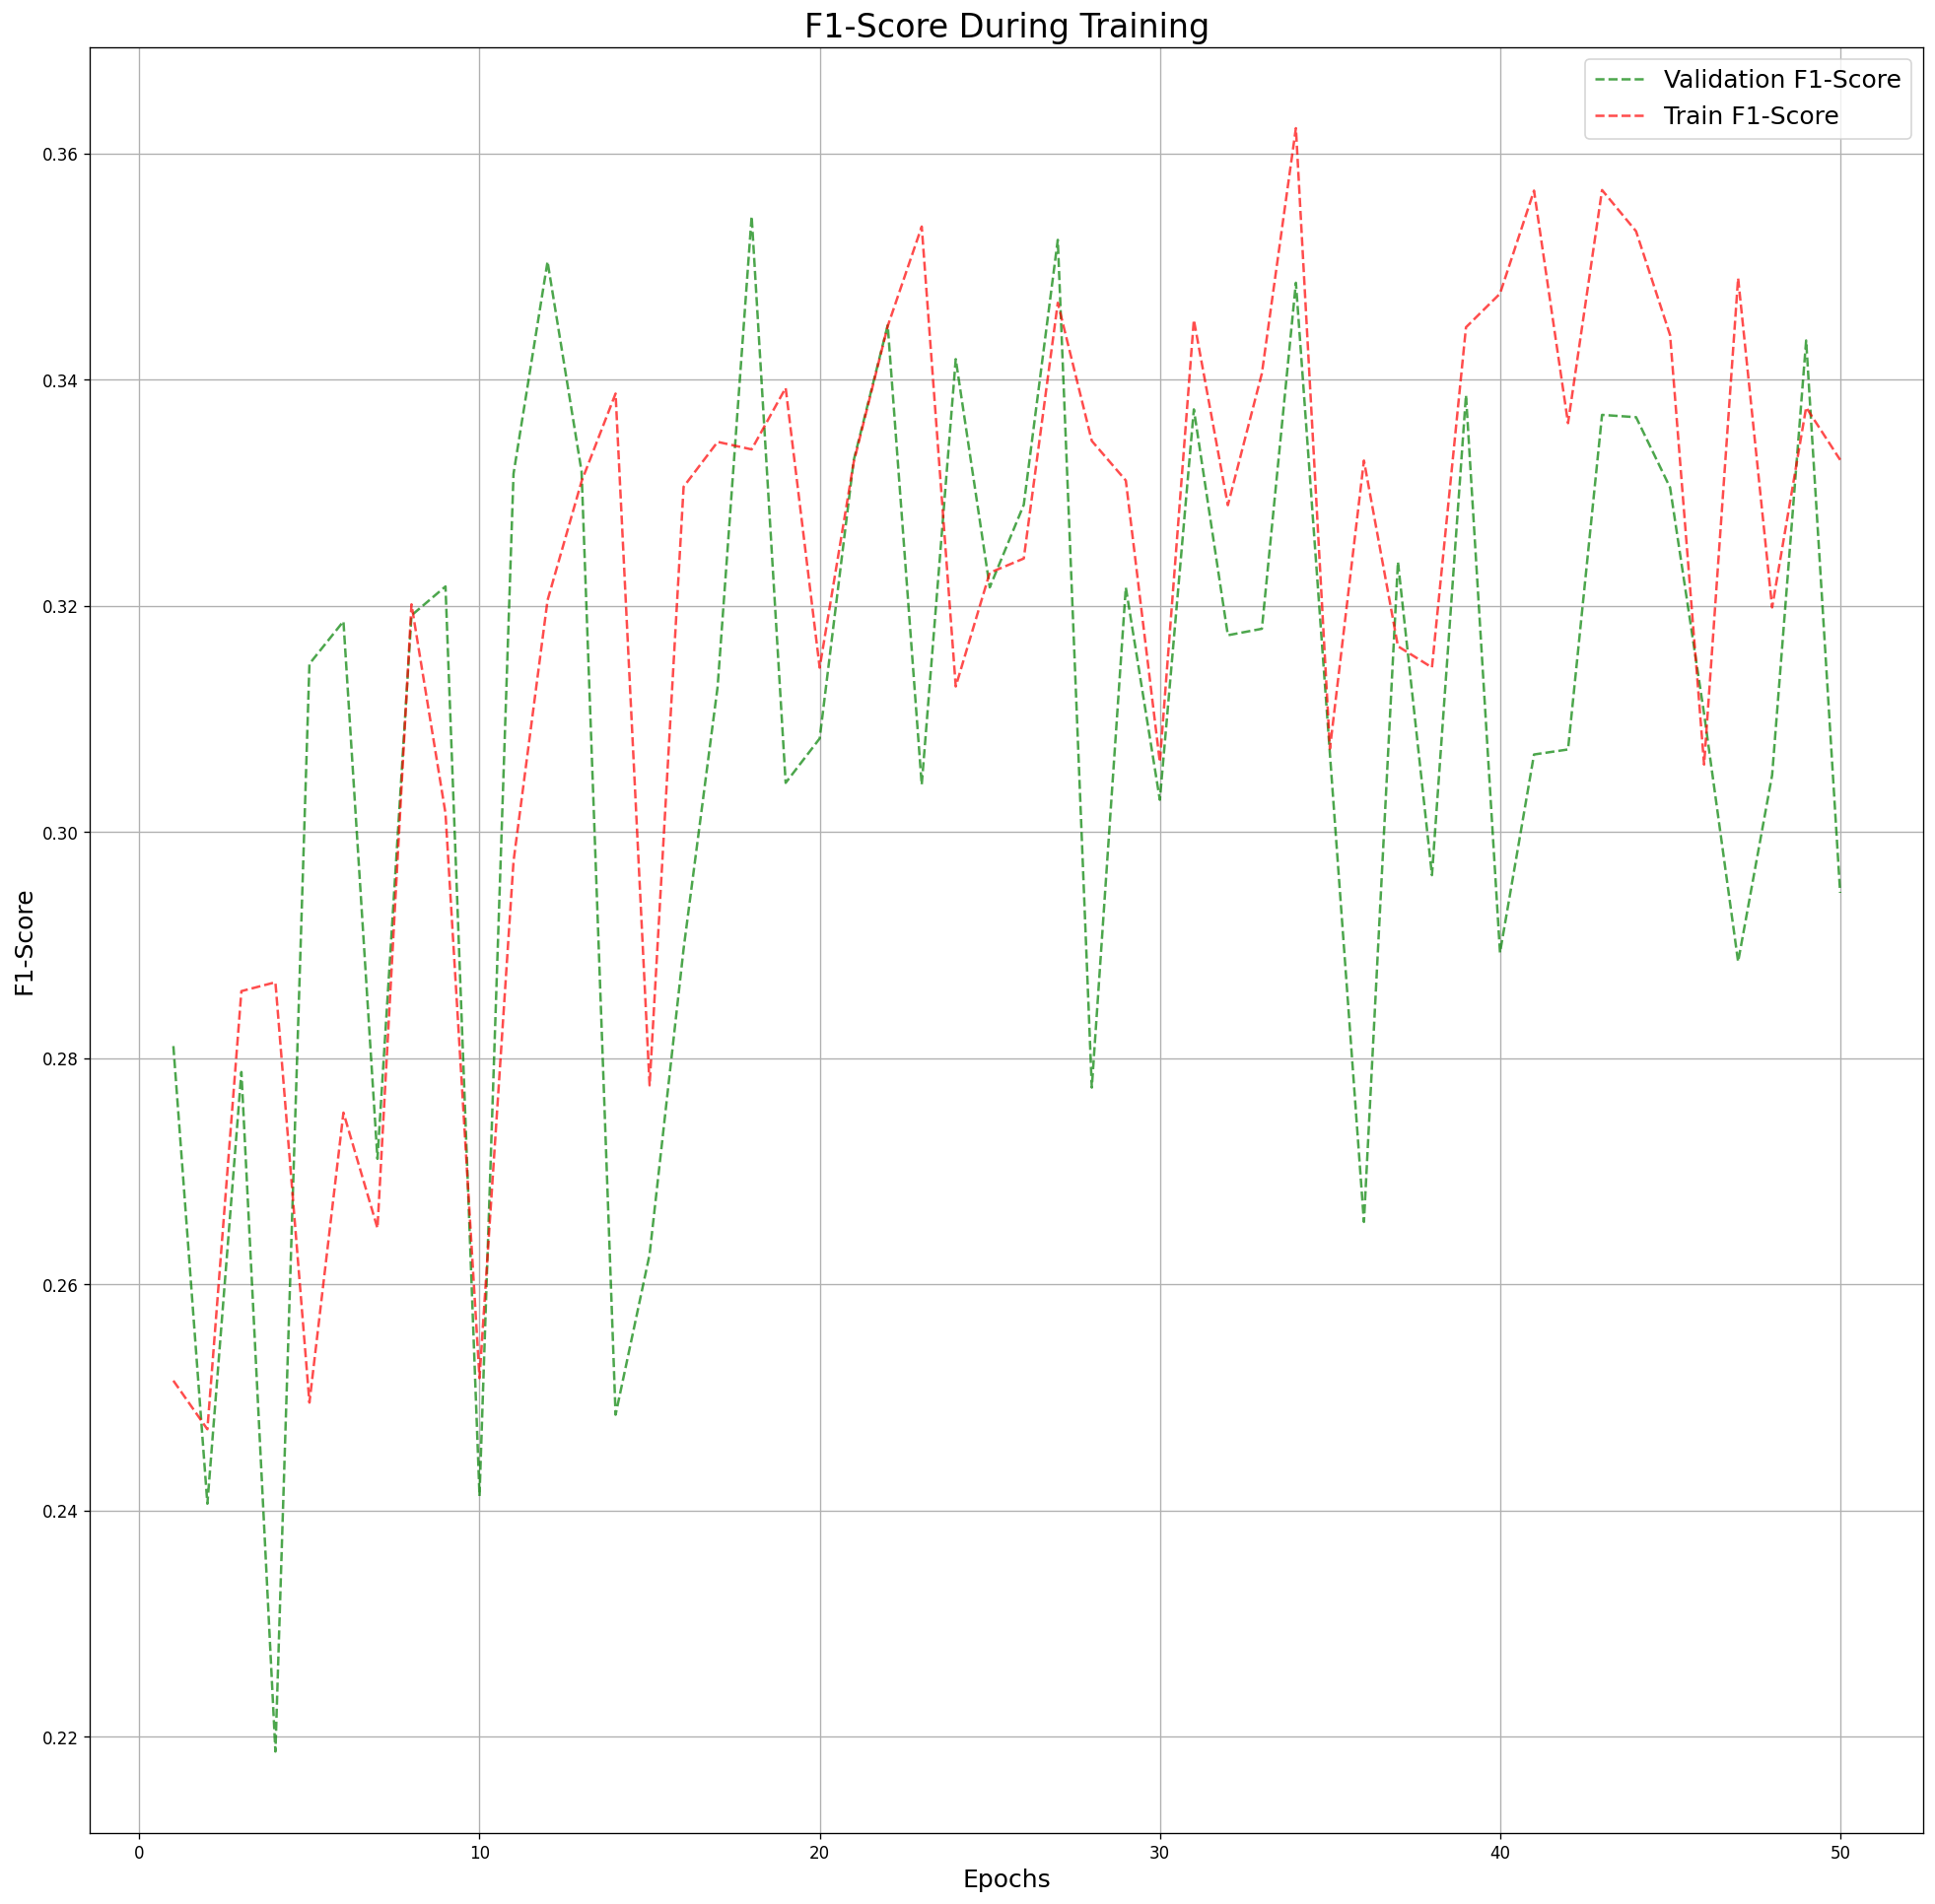

In [28]:
fig, axs = plt.subplots(figsize=(20,20), dpi=120)
axs.grid(True)
axs.set_title("F1-Score During Training", fontsize=20)
axs.set_xlabel("Epochs", fontsize=15)
axs.set_ylabel("F1-Score", fontsize=15)

n_epohchs = np.arange(len(train_metrics)) + 1
axs.plot(n_epohchs, [x[-2] for x in test_metrics], 'g--', label="Validation F1-Score", alpha=0.7)
axs.plot(n_epohchs, [x[-2] for x in train_metrics], 'r--', label="Train F1-Score", alpha=0.7)

axs.legend(loc='best', fontsize=15)

plt.show()

#### Test on unseen data

In [29]:
with torch.no_grad():
    classifier_model.eval()
    x_encoded  = torch.from_numpy(classifier_test[:,:,2:]).float().cuda() # eeg channels
    y = stress_2_label(np.diff(np.take(classifier_test[:,:,1], [0,-1], axis=-1)).squeeze(), n_classes).astype(int)
    y_hat = F.softmax(classifier_model(x_encoded).detach(), dim=-1).cpu().numpy()
    labels = y
    preds = y_hat

Precision: 0.45047853203146837
Recall: 0.36841607355270334
F1-Score: 0.30980644703514687


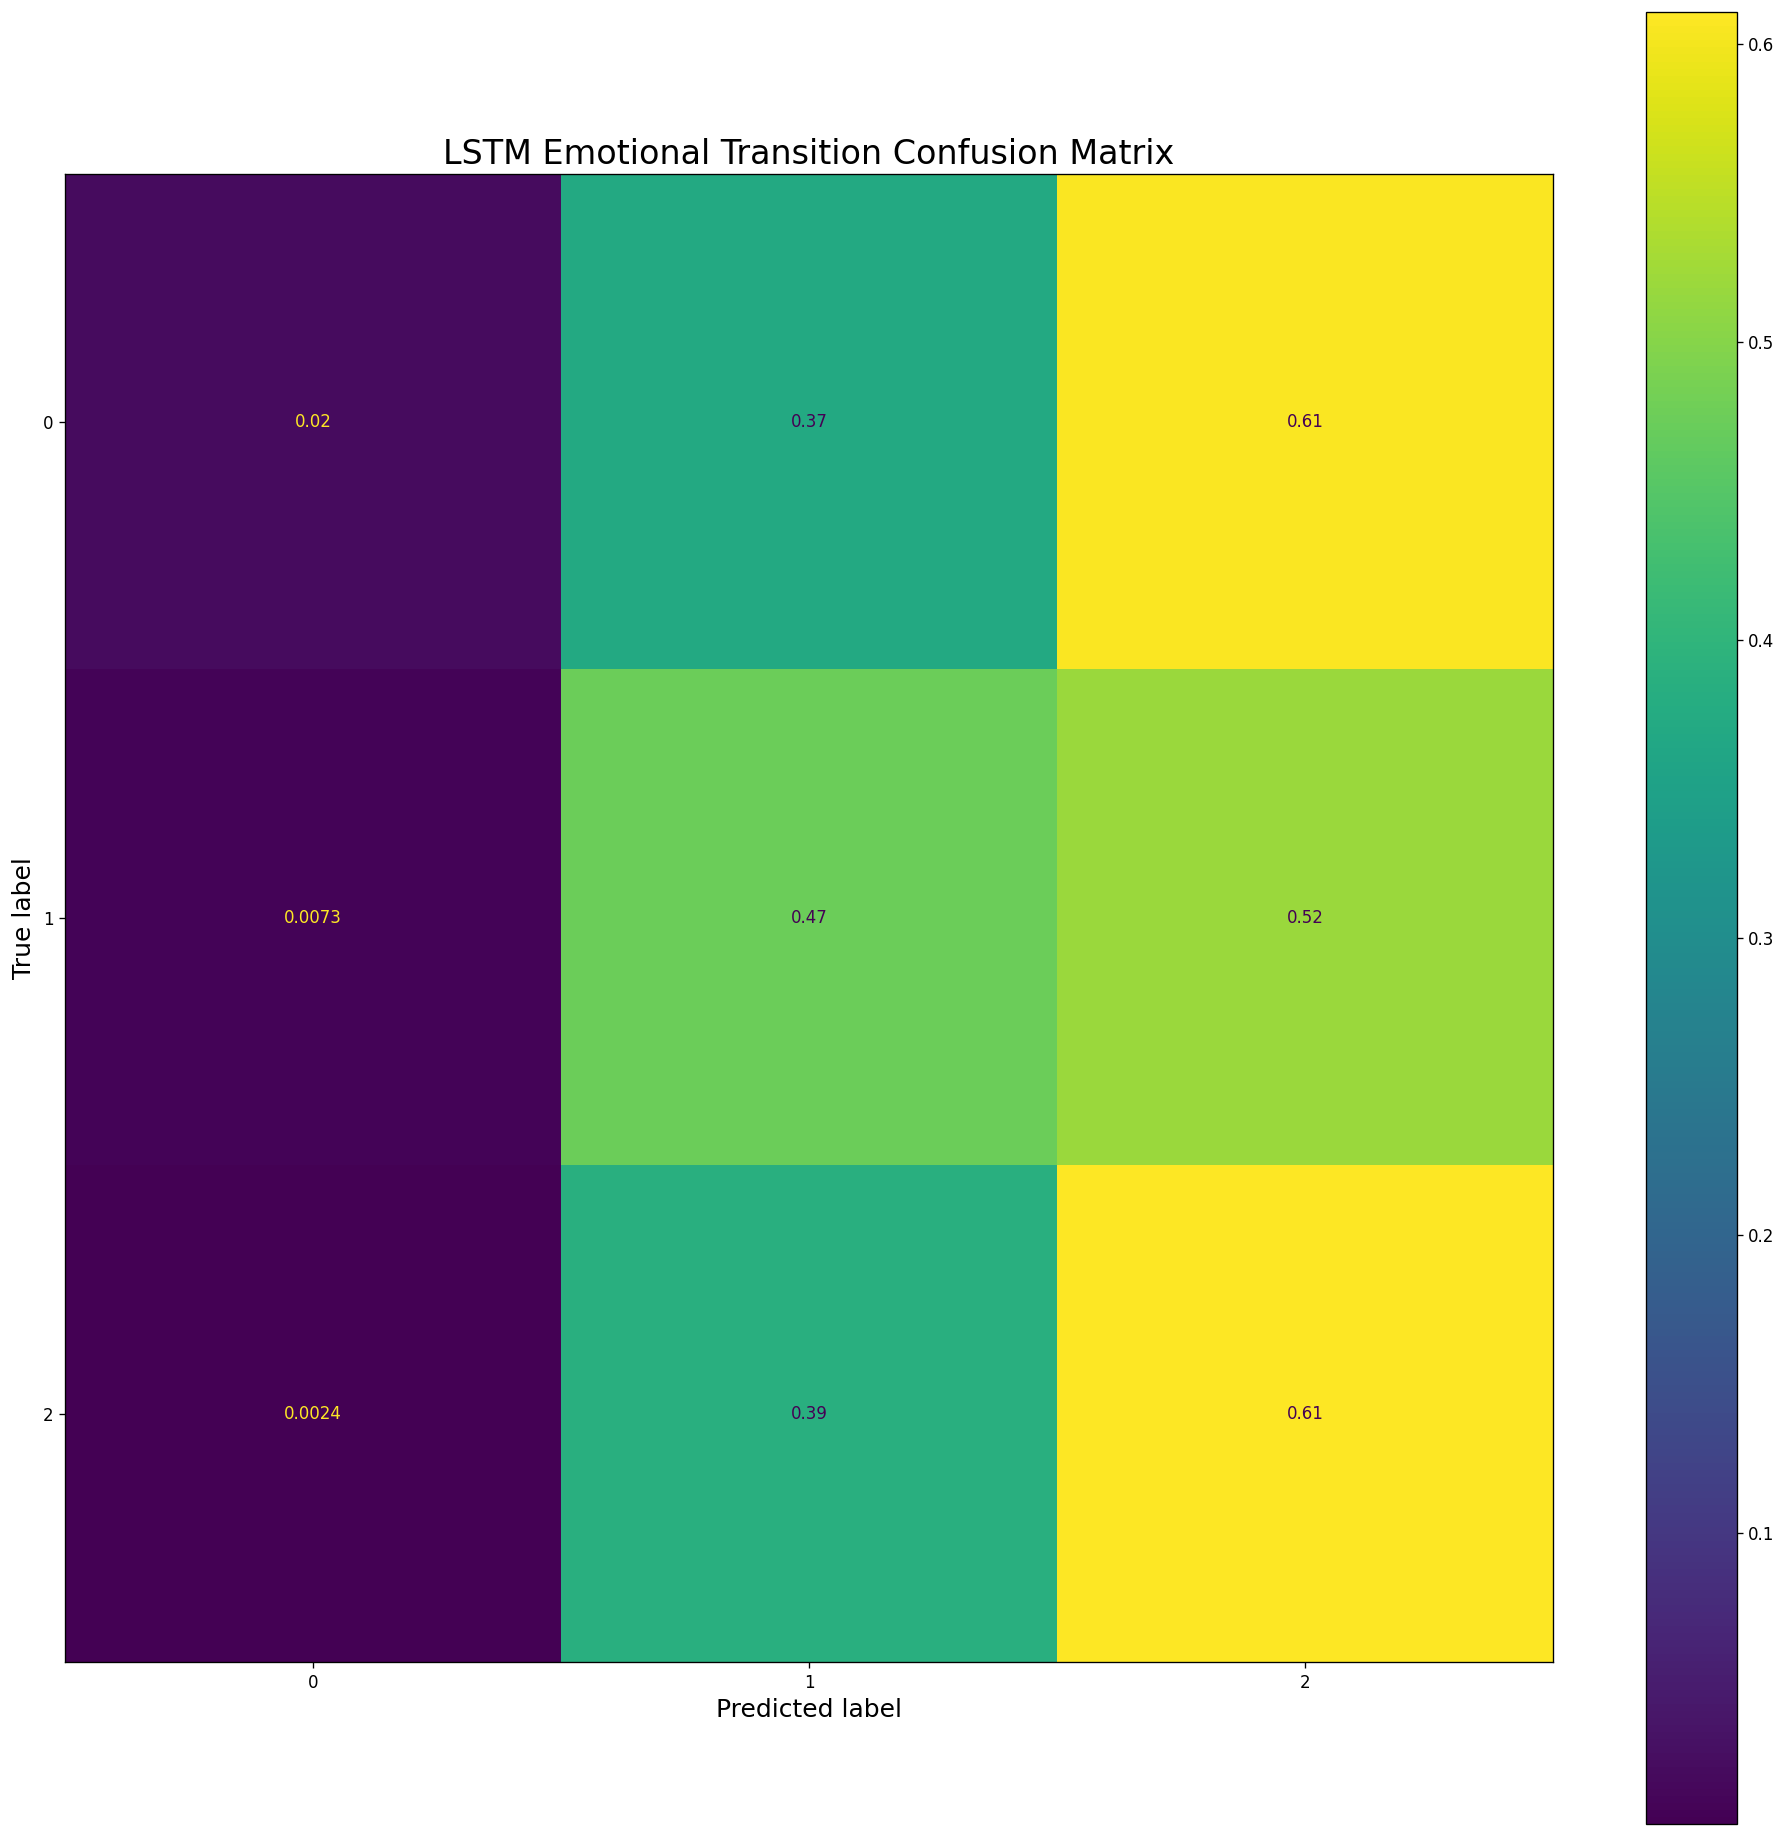

In [31]:
fig, axs = plt.subplots(figsize=(20,20), dpi=120)
axs.set_title("LSTM Emotional Transition Confusion Matrix", fontsize=20)
axs.set_xlabel("Predicted Label", fontsize=15)
axs.set_ylabel("True Label", fontsize=15)


prf = precision_recall_fscore_support(labels, np.array([x.argmax() for x in preds]), average='macro', zero_division=0)
print(f"Precision: {prf[0]}")
print(f"Recall: {prf[1]}")
print(f"F1-Score: {prf[2]}")

cm = confusion_matrix(labels, [x.argmax() for x in preds], labels=np.arange(n_classes), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(n_classes))

disp.plot(ax=axs)
plt.show()